<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-counterfactual-graph" data-toc-modified-id="Make-counterfactual-graph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make counterfactual graph</a></span></li><li><span><a href="#Walkthrough-of-make-counterfactual-graph" data-toc-modified-id="Walkthrough-of-make-counterfactual-graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Walkthrough of make counterfactual graph</a></span></li><li><span><a href="#ID*-algorithm" data-toc-modified-id="ID*-algorithm-3"></ul></div>

# Make counterfactual graph

$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$


**Lemma 24** Let $M$ be a model inducing $G$ containing variables $\alpha,\beta$ with the following properties: 
* $\alpha$ and $\beta$ have the same domain of values.
*  There is a bijection $f$ from $Pa(\alpha)$ to $Pa(\beta)$ such that a parent $\gamma$ and $f(\gamma)$ have the same domain of values. 
* The functional mechanisms of $\alpha$ and $\beta$ are the same (except whenever the function for $\alpha$ uses the parent $\gamma$, the corresponding function for $\beta$ uses $f (\gamma)$). 

Assume an observable variable set $\mathbf Z$ was observed to attain values $\mathbf{z}$ in $M_\mathbf{x}$, the submodel obtained from $M$ by forcing another observable variable set $\mathbf X$ to attain values $\mathbf x$. Assume further that for each $\gamma\in Pa(\alpha)$, either $f (\gamma) = \gamma$, or $\gamma$ and $f (\gamma)$ attain the same values (whether by observation or intervention). Then $\alpha$ and $\beta$ are the same random variable in $M_{\mathbf x}$ with observations $\mathbf z$.

$\textbf{Lemma 25}$. Let $M_\mathbf{x}$ be a submodel derived from $M$ with set $\mathbf Z$ observed to attain values $\mathbf z$, such that Lemma 24 holds for $\alpha, \beta$. Let $M'$ be a causal model obtained from $M$ by merging $\alpha, \beta$ into a new node $\omega$, which inherits all parents and the functional mechanism of $\alpha$. All children of $\alpha,\beta$ in $M'$ become children of $\omega$. Then $M_\mathbf{x}$,  $M'_\mathbf{x}$ agree on any distribution consistent with $\mathbf{z}$ being observed.



$\text{function }\mathbf{ make-cg}\left(G, \gamma\right) \\ \text{INPUT: } \text{ $G$ a causal diagram, $\gamma$ a conjunction of counterfactual events}. \\  \text{OUTPUT:  A counterfactual graph $G_\gamma$ and either a set of events $\gamma'$ such that $P(\gamma') = P(\gamma)$ or $\mathbf{Inconsistent}$} $

* Construct a submodel $G_{\mathbf{X}_i}$ for each action $do(\mathbf{x}_i)$ mentioned in $\gamma$. Construct the parallel worlds graph $G'$ by having all such graphs share their corresponding $U$ nodes.

* Let $\pi$ be a topological ordering of nodes in $G'$, let $\gamma':=\gamma.$
* Apply Lemmas 24 and 25, in order $\pi$ to each observable node pair $\alpha, \beta$ derived from the same variable in $G$. For each $\alpha, \beta$ that are the same, do:
    * Let $G'$ be modified as specified in Lemma 25
    * Modify $\gamma'$ by renaming all occurrences of $\beta$ to $\alpha$.
    * If $\mathbf{val}(\alpha)\neq \mathbf{val}(\beta)$, return $G', \mathbf{Inconsistent}$.
* $\texttt{return}$ $(G'_{An(\gamma')}, \gamma')$, where $An(\gamma')$ is the set of nodes in $G'$ ancestral to nodes corresponding to variables mentioned in $\gamma'$.

$$P(\lnot rxn_{do(\lnot catalyst)} | rxn, catalyst)$$

# Walkthrough of make counterfactual graph

In [1]:
from y0.algorithm.identify.cg import (
    make_parallel_worlds_graph,
    extract_interventions,
    make_counterfactual_graph,
    lemma_24_holds,
    is_pw_equivalent,
    has_same_function,
    merge_pw,
    is_inconsistent,
    update_event,
    parents_attain_same_values,
)
from y0.graph import NxMixedGraph
from y0.examples import (
    figure_9a,
    figure_9b,
    figure_9c,
    figure_9d,
    figure_11a,
    figure_11b,
    figure_11c,
)
from y0.dsl import (
    X,
    D,
    W,
    P,
    Y,
    Z,
    Event,
    CounterfactualVariable,
    Intervention,
    _get_treatment_variables,
    Variable,
    Zero,
)

x, y, z, w, d = -X, -Y, -Z, -W, -D

We illustrate the operation of make-cg by showing how the graph in Fig. 9 (c) is derived from the graph in Fig. 9 (a). We start the application of Lemma 24 from the topmost observable nodes, and conclude that the node pairs $D_x, D$, and $X_d, X$ have the same functional mechanisms, and the same parent set (in this case the parents are unobservable nodes $U_d$ for the first pair, and $U$ for the second). We then use Lemma 25 to obtain the graph shown in Fig. 11 (a). 
Since the node pairs are the same, we pick the name of one of the nodes of the pair to serve as the name of the new node. In our case, we picked D and X . Note that for this graph, and all subsequent intermediate graphs we generate, we use the convention that if a merge creates a situation where an unobservable variable has a single child, that variable is omitted from the graph. For instance, in Fig. 11 (a), the variable $U_d$ , and its corresponding arrow to $D$ omitted. 

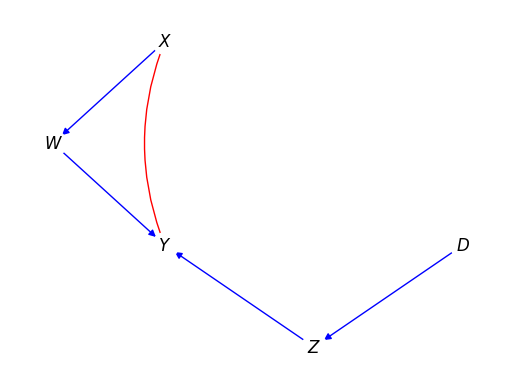

In [2]:
cf_graph_0 = figure_9a.graph
cf_graph_0.draw()

![Figure9A.PNG](images/factual-world.PNG)


We have two interventions here, D and X are being intervened on.  

In [3]:
P(Y @ X | ~X, Z @ D, D)

P(Y @ -X | D, +X, Z @ -D)

In [4]:
final_graph = make_counterfactual_graph(figure_9a.graph, {Y @ +x: +y, X: -x, Z @ -d: -z, D: -d})

In [5]:
cf_graph_1 = make_parallel_worlds_graph(figure_9a.graph, {frozenset([+x]), frozenset([-d])})

![Figure9B.PNG](images/parallel-worlds.png)


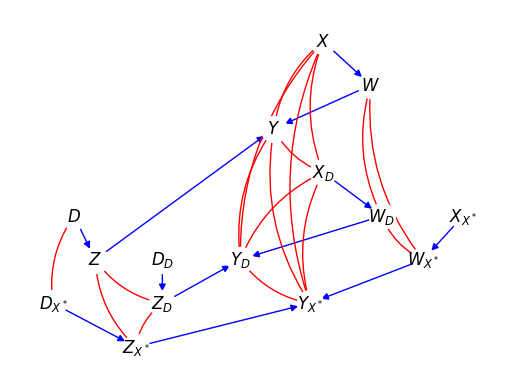

In [6]:
cf_graph_1.draw()

cf_graph_1 should be a stitched together graph of counterfactual worlds that corresponds to Figure 9b.
Now we will start merging nodes that are equivalent in the two graphs using the topological ordering of (X,D,W,Z,Y)

In [7]:
# Does Lemma 24 hold for X and X @ D?  Then Merge them together.
if lemma_24_holds(cf_graph_1, {Y @ +x: +y, D: -d, Z @ -d: -z, X: -x}, X, X @ D):
    cf_graph_2, preferred_node, eliminated_node = merge_pw(cf_graph_1, X, X @ D)

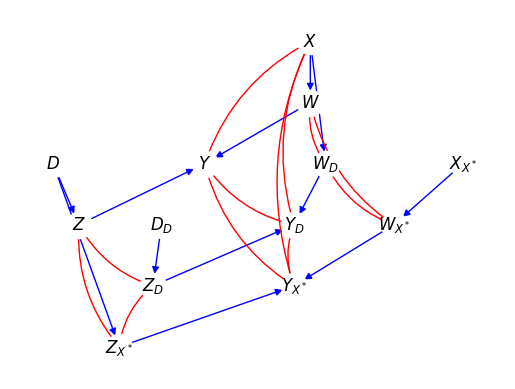

In [8]:
# Next we merge D and D @ ~X
cf_graph_3, preferred_node, eliminated_node = merge_pw(cf_graph_2, D, D @ ~X)
figure_11a_calculated = cf_graph_3
figure_11a_calculated.draw()

![Figure11A.PNG](images/step-2-make-counterfactual.png)


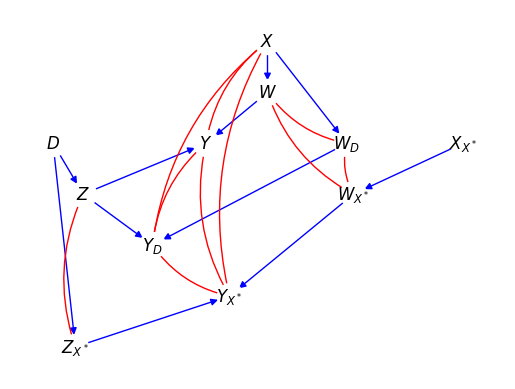

In [9]:
cf_graph_z, preferred_node, eliminated_node = merge_pw(cf_graph_3, Z, Z @ -d)
cf_graph_z.draw()

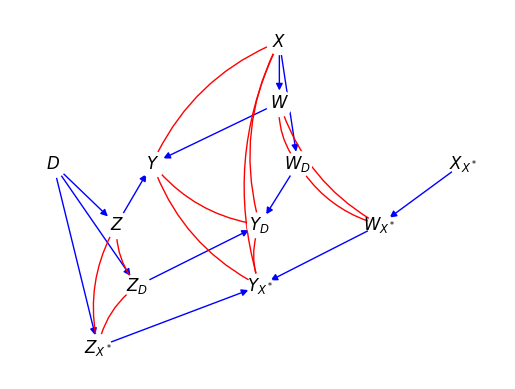

In [10]:
# We no longer need to merge D and D @ D
cf_graph_4, preferred_node, eliminated_node = merge_pw(cf_graph_3, D, D @ D)
cf_graph_4.draw()

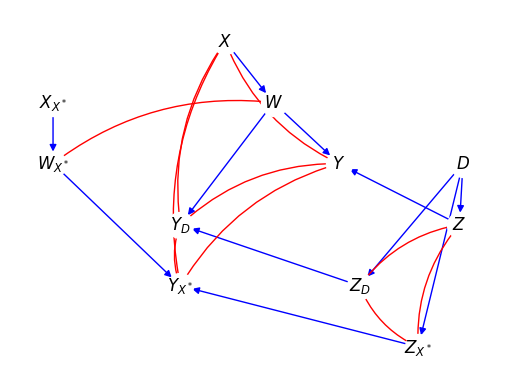

In [11]:
# Next we merge W and W @ D
cf_graph_5, preferred_node, eliminated_node = merge_pw(cf_graph_4, W, W @ D)
cf_graph_5.draw()

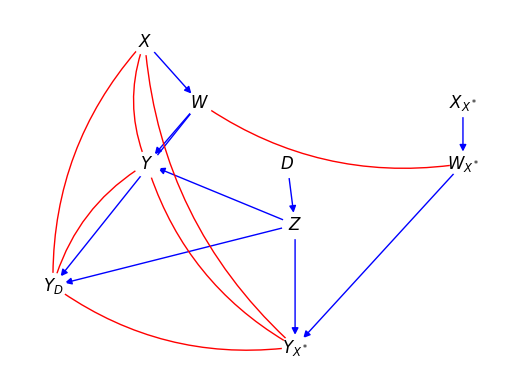

In [12]:
# Next we merge Z, Z @ D, and Z @ ~X
cf_graph_6, preferred_node, eliminated_node = merge_pw(cf_graph_5, Z, Z @ D)
cf_graph_7, preferred_node, eliminated_node = merge_pw(cf_graph_6, Z, Z @ ~X)
figure_11b_calculated = cf_graph_7
figure_11b_calculated.draw()

![Figure11B.PNG](images/step-4-make-counterfactual.PNG)

In [13]:
# Finally we merge Y and Y @ D
cf_graph_8, preferred_node, eliminated_node = merge_pw(cf_graph_7, Y, Y @ D)
figure_11c_calculated = cf_graph_8

![Figure11C.PNG](images/step-5-make-counterfactual.png)

The last line of `make-counterfactual-graph()` removes all nodes that are not ancestors of the events $\left\{y_{do(X=x')}, z, d\right\}$. Thus we remove $\{Y, W\}$

![Figure9C.PNG](images/counterfactual-graph.png)

In [14]:
for node in figure_11c_calculated.nodes():
    print(node)

X
W
Y
D
Z
X @ +X
W @ +X
Y @ +X


In [15]:
for node in figure_11c.graph.nodes():
    print(node)

X @ +X
W @ +X
Y @ +X
D
Z
Y
X
W


In [16]:
final_graph[0].nodes()

NodeView((X, D, Y @ +X, W @ +X, Z, X @ +X))

# Examples of Notation


In [17]:
W @ X

W @ -X

In [18]:
~W

+W

In [19]:
P(Y @ X | ~X, Z @ D, D)

P(Y @ -X | D, +X, Z @ -D)

In [20]:
{Y @ X: y}, {Y @ X: ~y}

({Y @ -X: -Y}, {Y @ -X: +Y})

In [21]:
P(+Y @ +X)

P(+Y @ +X)

In [22]:
P({Y @ +x: y})

P(Y @ +X)